In [3]:

# Useful links
# http://www.pygame.org/wiki/OBJFileLoader
# https://rdmilligan.wordpress.com/2015/10/15/augmented-reality-using-opencv-opengl-and-blender/
# https://clara.io/library

# TODO -> Implement command line arguments (scale, model and object to be projected)
#      -> Refactor and organize code (proper funcition definition and separation, classes, error handling...)

import argparse

import cv2
import numpy as np
import math
import os
from objloader_simple import *

# Minimum number of matches that have to be found
# to consider the recognition valid
MIN_MATCHES = 10  


def main():
    """
    This functions loads the target surface image,
    """
    homography = None 
    # matrix of camera parameters (made up but works quite well for me) 
    camera_parameters = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])
    # create ORB keypoint detector
    orb = cv2.ORB_create()
    # create BFMatcher object based on hamming distance  
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # load the reference surface that will be searched in the video stream
    dir_name = os.getcwd()
    model = cv2.imread(os.path.join(dir_name, 'reference/model.jpg'), 0)
    # Compute model keypoints and its descriptors
    kp_model, des_model = orb.detectAndCompute(model, None)
    # Load 3D model from OBJ file
    obj = OBJ(os.path.join(dir_name, 'models/fox.obj'), swapyz=True)  
    # init video capture
    cap = cv2.VideoCapture(0)
    
    try:
        while True:
            # read the current frame
            ret, frame = cap.read()
            if not ret:
                print ("Unable to capture video")
                return 
            # find and draw the keypoints of the frame
            kp_frame, des_frame = orb.detectAndCompute(frame, None)
            # match frame descriptors with model descriptors
            matches = bf.match(des_model, des_frame)
            # sort them in the order of their distance
            # the lower the distance, the better the match
            matches = sorted(matches, key=lambda x: x.distance)

            # compute Homography if enough matches are found
            if len(matches) > MIN_MATCHES:
                # differenciate between source points and destination points
                src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                # compute Homography
                homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                if rectangle:
                    # Draw a rectangle that marks the found model in the frame
                    h, w = model.shape
                    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                    # project corners into frame
                    dst = cv2.perspectiveTransform(pts, homography)
                    # connect them with lines  
                    frame = cv2.polylines(frame, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)  
                # if a valid homography matrix was found render cube on model plane
                if homography is not None:
                    try:
                        # obtain 3D projection matrix from homography matrix and camera parameters
                        projection = projection_matrix(camera_parameters, homography)  
                        # project cube or model
                        frame = render(frame, obj, projection, model, False)
                        #frame = render(frame, model, projection)
                    except:
                        pass
                # draw first 10 matches.
                if match:
                    frame = cv2.drawMatches(model, kp_model, frame, kp_frame, matches[:10], 0, flags=2)
                # show result
                cv2.imshow('frame', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            else:
                print ("Not enough matches found - %d/%d" % (len(matches), MIN_MATCHES))

        cv2.destroyAllWindows()
    except KeyboardInterrupt:
        # Release the Video Device
        cap.release()
        # Message to be displayed after releasing the device
        print ("Released Video Resource")
    return 0

def render(img, obj, projection, model, color=False):
    """
    Render a loaded obj model into the current video frame
    """
    vertices = obj.vertices
    scale_matrix = np.eye(3) * 2
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)
        if color is False:
            cv2.fillConvexPoly(img, imgpts, (137, 27, 211))
        else:
            color = hex_to_rgb(face[-1])
            color = color[::-1]  # reverse
            cv2.fillConvexPoly(img, imgpts, color)

    return img

def projection_matrix(camera_parameters, homography):
    """
    From the camera calibration matrix and the estimated homography
    compute the 3D projection matrix
    """
    # Compute rotation along the x and y axis as well as the translation
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

def hex_to_rgb(hex_color):
    """
    Helper function to convert hex strings to RGB
    """
    hex_color = hex_color.lstrip('#')
    h_len = len(hex_color)
    return tuple(int(hex_color[i:i + h_len // 3], 16) for i in range(0, h_len, h_len // 3))


# Command line argument parsing
# NOT ALL OF THEM ARE SUPPORTED YET
# parser = argparse.ArgumentParser(description='Augmented reality application')

# parser.add_argument('-r','--rectangle', help = 'draw rectangle delimiting target surface on frame', action = 'store_true')
# parser.add_argument('-mk','--model_keypoints', help = 'draw model keypoints', action = 'store_true')
# parser.add_argument('-fk','--frame_keypoints', help = 'draw frame keypoints', action = 'store_true')
# parser.add_argument('-ma','--matches', help = 'draw matches between keypoints', action = 'store_true')
# TODO jgallostraa -> add support for model specification
#parser.add_argument('-mo','--model', help = 'Specify model to be projected', action = 'store_true')

match = True
rectangle = True

# if __name__ == '__main__':
main()


0

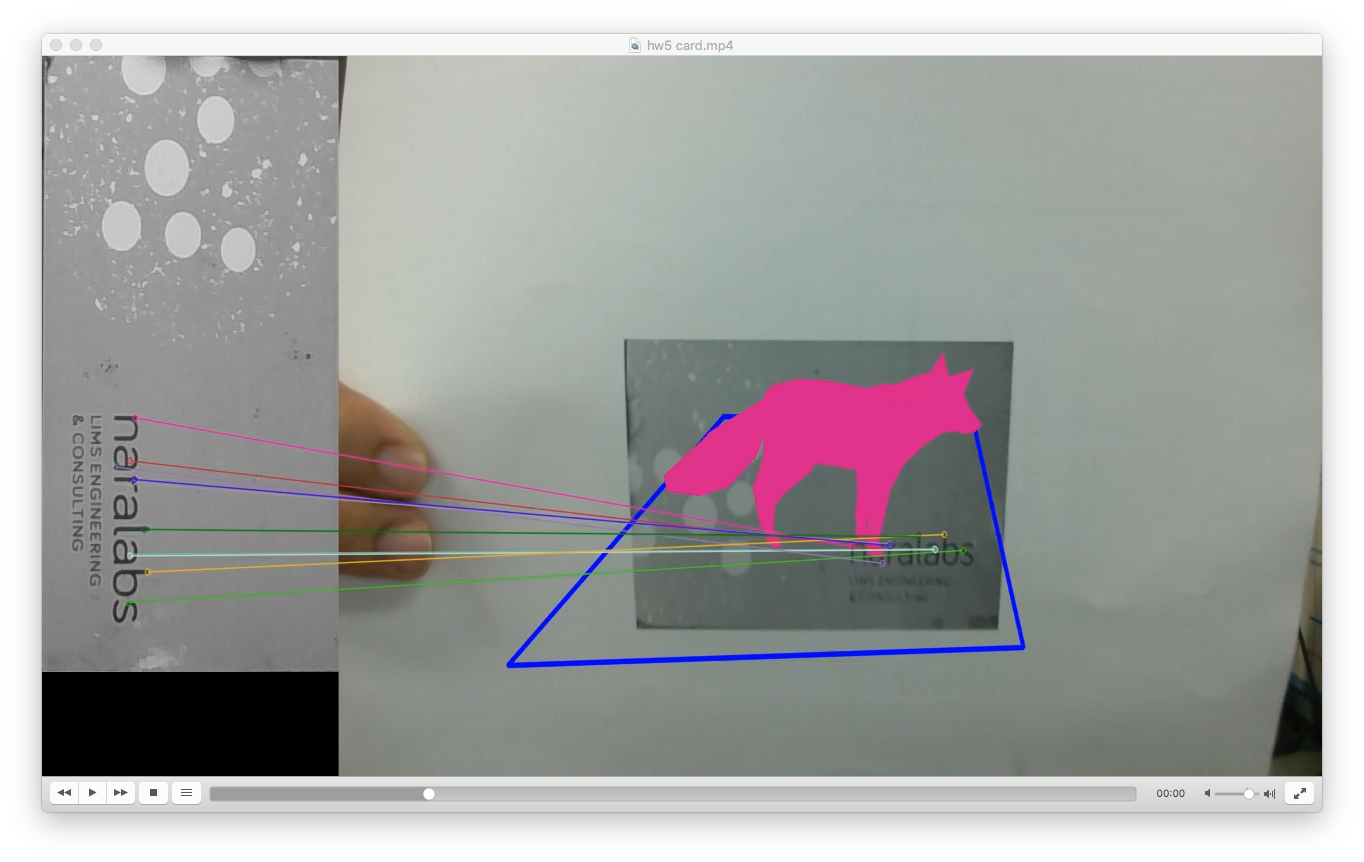

In [4]:
from IPython.display import Image
Image("1.png")

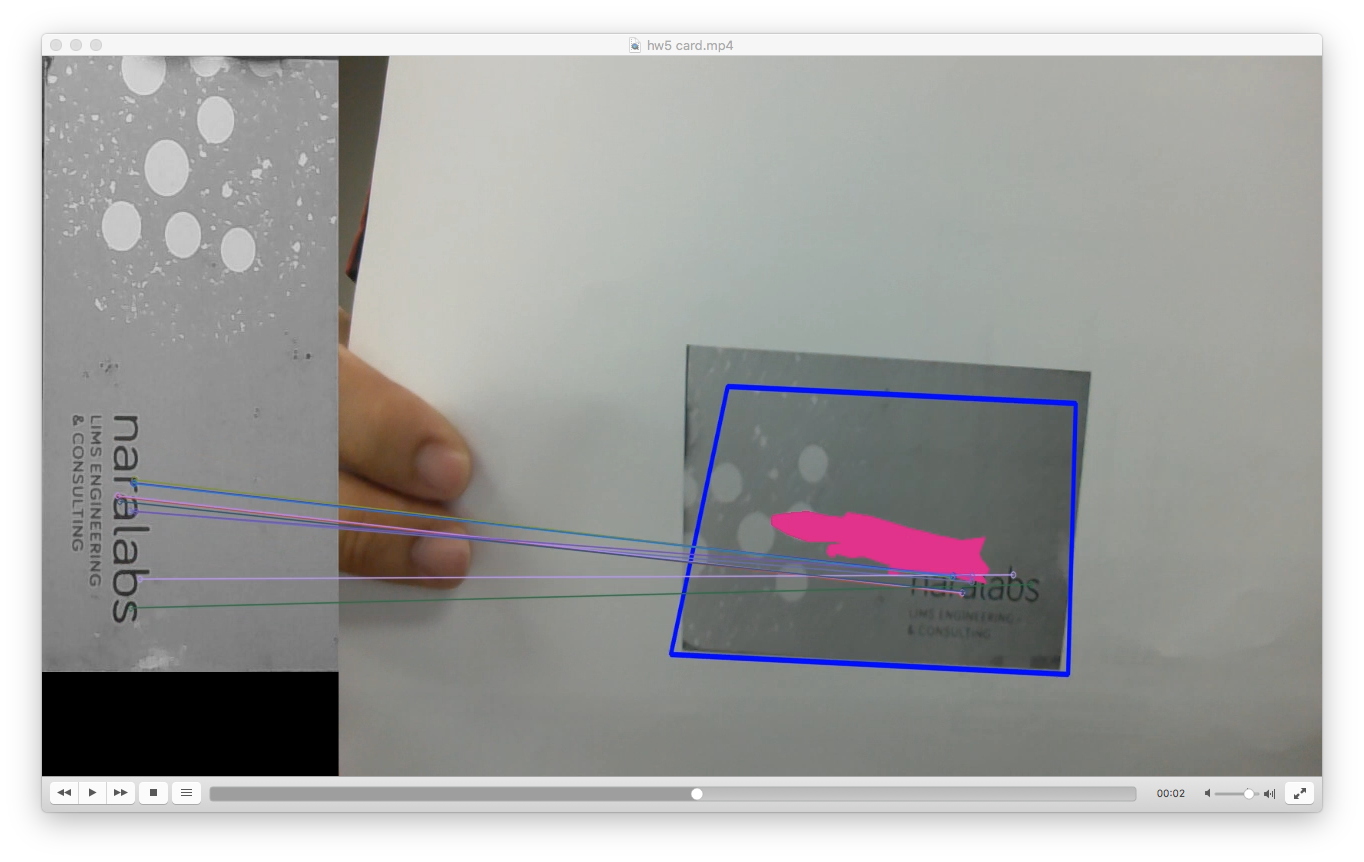

In [5]:
from IPython.display import Image
Image("2.png")

In [6]:
from IPython.display import HTML

HTML("""<video width="500" height="500" controls><source src="hw5 card.mp4" type="video/mp4"></video>""")